# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from dateutil.parser import parse

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [5]:
with pd.HDFStore('data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [6]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",27981,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",42942,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",23467,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",41274,1551152,2013 (1888)
ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",43251,815094,1981


In [7]:
with pd.HDFStore('data/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

## Compute Inputs

### Compute Returns

In [8]:
start = 2008
end = 2017

Create month-end monthly returns and drop dates that have no observations:

In [9]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APH     521 non-null    float64
 1   PPL     521 non-null    float64
 2   HST     521 non-null    float64
 3   LLY     521 non-null    float64
 4   GIS     521 non-null    float64
 5   EXR     521 non-null    float64
 6   C       521 non-null    float64
 7   TXN     521 non-null    float64
 8   AEP     521 non-null    float64
 9   BR      521 non-null    float64
 10  ES      521 non-null    float64
 11  D       521 non-null    float64
 12  RJF     521 non-null    float64
 13  SNA     521 non-null    float64
 14  BAC     521 non-null    float64
 15  CRM     521 non-null    float64
 16  MHK     521 non-null    float64
 17  WAB     521 non-null    float64
 18  CCL     521 non-null    float64
 19  CPT     521 non-null    float64
 20  DXCM    521 non-null    float64
 21  ILMN    

### Set  Parameters

In [10]:
stocks = weekly_returns.columns

In [11]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(29, 521)

In [12]:
NUM_PF = 100000 # no of portfolios to simulate

In [13]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [14]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

### Compute Mean Returns, Covariance and Precision Matrix

In [15]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

The precision matrix is the inverse of the covariance matrix:

In [16]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [17]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [18]:
treasury_10yr_monthly

DATE
2008-01-31    0.000706
2008-02-29    0.000679
2008-03-31    0.000663
2008-04-30    0.000725
2008-05-31    0.000781
                ...   
2016-08-31    0.000304
2016-09-30    0.000308
2016-10-31    0.000354
2016-11-30    0.000456
2016-12-31    0.000471
Freq: M, Name: DGS10, Length: 108, dtype: float64

In [19]:
treasury_10yr_monthly.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 108 entries, 2008-01-31 to 2016-12-31
Freq: M
Series name: DGS10
Non-Null Count  Dtype  
--------------  -----  
108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [20]:
rf_rate = treasury_10yr_monthly.mean()
rf_rate

0.0004989138176638176

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [21]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [22]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [23]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.413797e-02,3.482711e-02,3.454511e-02,3.453747e-02,3.366944e-02,3.456012e-02,3.387530e-02,3.494031e-02,3.512988e-02,3.484181e-02,...,3.438209e-02,3.453769e-02,3.430568e-02,3.458819e-02,3.475868e-02,3.420019e-02,3.446148e-02,3.475231e-02,3.417669e-02,3.443485e-02
std,1.159536e-01,1.178263e-01,1.167515e-01,1.159635e-01,1.144218e-01,1.165634e-01,1.151098e-01,1.171707e-01,1.179236e-01,1.178112e-01,...,1.163960e-01,1.163222e-01,1.157667e-01,1.168369e-01,1.174727e-01,1.164666e-01,1.169692e-01,1.177618e-01,1.158147e-01,1.170633e-01
min,8.793056e-107,4.704445e-127,2.181477e-96,4.022396e-96,1.916500e-108,2.400180e-94,2.188566e-104,5.929795e-117,5.443157e-94,2.465120e-109,...,1.149177e-109,3.203865e-102,7.894373e-101,3.405373e-92,1.555861e-107,8.432533e-109,2.210357e-104,6.604910e-103,1.092396e-89,1.680188e-101
25%,5.298395e-13,5.221527e-13,5.645136e-13,6.547431e-13,4.928097e-13,5.421686e-13,4.738478e-13,5.639132e-13,5.466463e-13,5.825952e-13,...,7.022169e-13,5.453133e-13,5.506179e-13,6.383704e-13,5.660993e-13,6.607866e-13,5.965358e-13,5.237537e-13,6.011445e-13,5.095366e-13
50%,5.558765e-07,5.852846e-07,6.058194e-07,6.538304e-07,5.759114e-07,6.080189e-07,5.440480e-07,5.919575e-07,5.880280e-07,5.543249e-07,...,6.122808e-07,5.800062e-07,5.366644e-07,6.343576e-07,5.599734e-07,5.877195e-07,5.598825e-07,5.648444e-07,6.213022e-07,5.531863e-07
75%,1.913742e-03,1.967075e-03,1.933750e-03,2.097607e-03,1.918707e-03,1.918605e-03,1.857478e-03,2.011346e-03,1.931025e-03,1.961998e-03,...,1.860283e-03,1.900752e-03,1.915189e-03,1.991105e-03,1.845780e-03,1.887393e-03,1.907257e-03,1.933631e-03,1.845766e-03,1.789637e-03
max,9.995527e-01,9.998688e-01,9.982761e-01,9.965666e-01,9.978061e-01,9.931378e-01,9.974835e-01,9.920827e-01,9.996496e-01,9.966858e-01,...,9.987076e-01,9.945383e-01,9.956820e-01,9.978903e-01,9.989101e-01,9.980890e-01,9.999540e-01,9.996421e-01,9.964291e-01,9.987472e-01


### Plot Simulated Portfolios

Max Sharpe: 19.82%, 23.87%


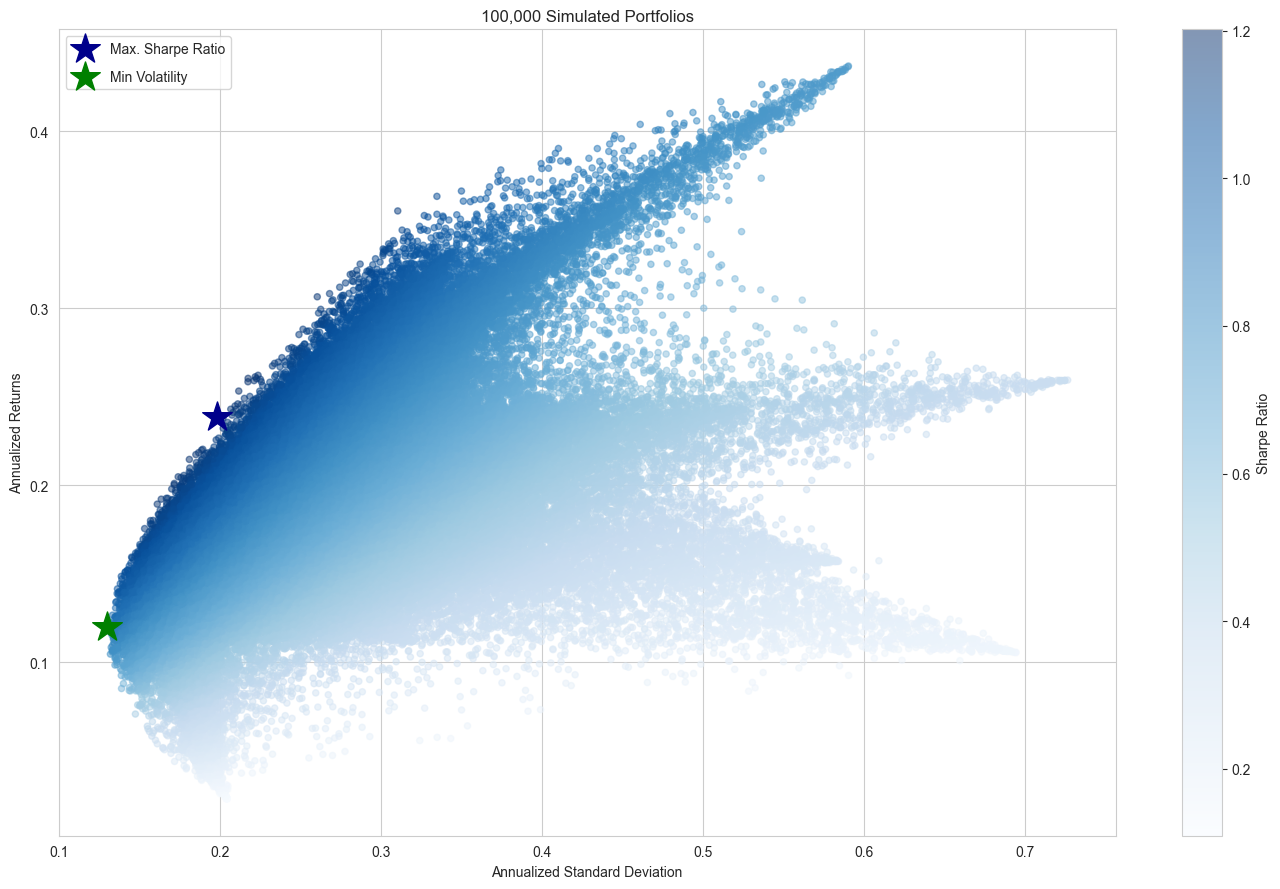

In [24]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [25]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [26]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [27]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [28]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [29]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [30]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [31]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [32]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [33]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [34]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [35]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.280407            0.191826       0.718045
std                         0.094152            0.055663       0.190364
min                         0.128814            0.023142       0.110943
25%                         0.208270            0.152483       0.594084
50%                         0.265070            0.187943       0.745578
75%                         0.326888            0.223278       0.860121
max                         0.724154            0.437680       1.194240


In [36]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.185134
Annualized Returns               0.221594
Sharpe Ratio                     1.194240
Name: 9932, dtype: float64

### Get Max Sharpe PF

In [37]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [38]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.222658
sd     0.171642
sr     1.294315
dtype: float64

From simulated pf data

### Get Min Vol PF

In [39]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [40]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

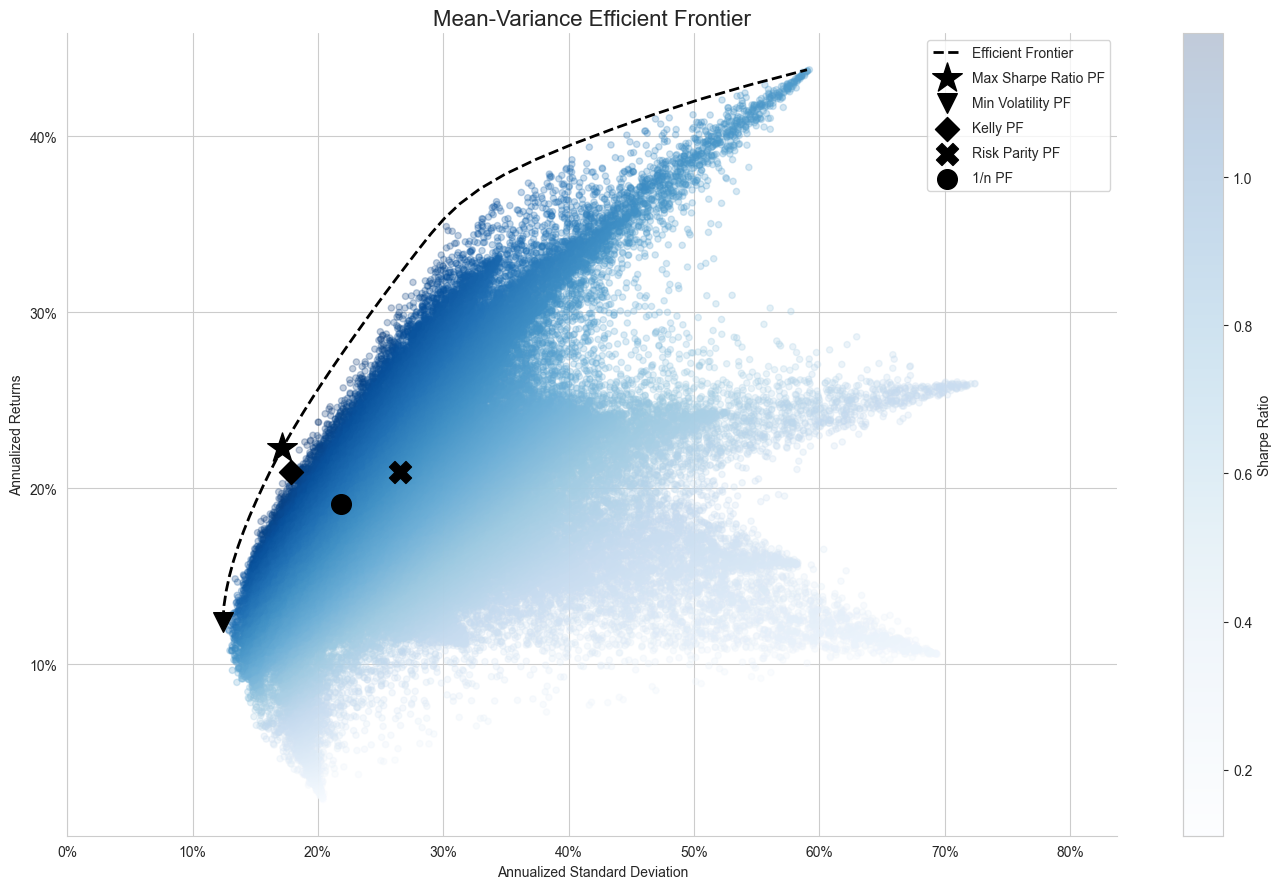

In [41]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();

## <font color='red'>A股数据</font>

In [42]:
with pd.HDFStore('Adata/assets.h5') as store:
    prices = (store['csmar/aprices']
              .adj_close
              .unstack('name')
              .sample(n=30, axis=1))

prices.head()

name,乐普医疗,中国长城,天赐材料,华润微,璞泰来,北方稀土,视源股份,欣旺达,中国中冶,江西铜业,...,同仁堂,星宇股份,三峡能源,汇顶科技,浙江龙盛,中国铝业,中国中铁,中航沈飞,科大讯飞,工商银行
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,81.689681,53.423352,54.302505,NaN,46.420816,169.853984,90.638475,58.126193,3.407951,20.474568,...,293.935671,58.349848,NaN,73.891569,167.771565,3.571766,7.834706,136.623886,335.436359,8.858657
2019-01-03,80.361742,54.217330,54.506267,NaN,45.264569,172.394953,89.164020,54.945831,3.407951,20.443044,...,292.832723,57.617371,NaN,73.354728,158.678738,3.592176,7.891727,141.333363,340.794767,8.858657
2019-01-04,83.017620,56.145561,55.270374,NaN,45.968372,179.431482,91.221776,56.028507,3.441253,20.774042,...,295.810683,55.730312,NaN,73.435761,161.174808,3.643201,7.994365,143.393759,363.434042,8.977908
2019-01-07,82.246559,57.052964,57.002349,NaN,46.712392,181.386073,93.668399,57.178851,3.452354,21.341467,...,293.825376,57.480807,NaN,74.904476,163.136006,3.694226,8.028578,150.752317,392.101526,8.926800
2019-01-08,82.160885,56.372412,59.167318,NaN,49.085213,179.040563,93.004084,61.847893,3.363547,21.089278,...,290.406237,56.835234,NaN,75.562866,163.492587,3.684021,8.039982,150.899488,388.752521,8.858657


In [43]:
start = 2019
end = 2021

In [44]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2019-01-13 to 2022-01-02
Freq: W-SUN
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   乐普医疗    156 non-null    float64
 1   中国长城    156 non-null    float64
 2   天赐材料    156 non-null    float64
 3   璞泰来     156 non-null    float64
 4   北方稀土    156 non-null    float64
 5   视源股份    156 non-null    float64
 6   欣旺达     156 non-null    float64
 7   中国中冶    156 non-null    float64
 8   江西铜业    156 non-null    float64
 9   伊利股份    156 non-null    float64
 10  国轩高科    156 non-null    float64
 11  通威股份    156 non-null    float64
 12  高德红外    156 non-null    float64
 13  包钢股份    156 non-null    float64
 14  科沃斯     156 non-null    float64
 15  中金黄金    156 non-null    float64
 16  藏格矿业    156 non-null    float64
 17  同仁堂     156 non-null    float64
 18  星宇股份    156 non-null    float64
 19  汇顶科技    156 non-null    float64
 20  浙江龙盛    156 non-null    float64
 21  中国铝业    

In [45]:
a_rf_day = pd.read_csv("Adata/Arf/FE_BONDYIELDSD.csv",parse_dates=['StatsDate'],infer_datetime_format=True)
a_rf_day.columns = ['date','rf']
a_rf_day.set_index('date',inplace=True)
a_rf_day.head()

a_rf_monthly= a_rf_day.resample('M').last().div(periods_per_year).div(100).squeeze()

rf_rate = a_rf_monthly.mean()
rf_rate

0.0005921955128205128

### Set  Parameters

In [46]:
stocks = weekly_returns.columns

In [47]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(26, 156)

In [48]:
NUM_PF = 100000 # no of portfolios to simulate

In [49]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [50]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

39

### Compute Mean Returns, Covariance and Precision Matrix

In [51]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [52]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

## Simulate Random Portfolios

In [53]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.861244e-02,3.824319e-02,3.923933e-02,3.903979e-02,3.893454e-02,3.866703e-02,3.834171e-02,3.758031e-02,3.837464e-02,3.819642e-02,...,3.809284e-02,3.858988e-02,3.734233e-02,3.812428e-02,3.852043e-02,3.912335e-02,3.868885e-02,3.852565e-02,3.826169e-02,3.819448e-02
std,1.268065e-01,1.264551e-01,1.283055e-01,1.280893e-01,1.283729e-01,1.274740e-01,1.263473e-01,1.255346e-01,1.261741e-01,1.264202e-01,...,1.257295e-01,1.266698e-01,1.242901e-01,1.250929e-01,1.267950e-01,1.281903e-01,1.272329e-01,1.269424e-01,1.266314e-01,1.262956e-01
min,1.237451e-114,6.918007e-115,7.505467e-95,1.326561e-97,1.630044e-93,1.707340e-88,5.741470e-99,3.028444e-100,1.741175e-96,2.088739e-126,...,7.170554e-103,2.219898e-95,3.686965e-86,1.519719e-111,6.126255e-120,5.481464e-91,1.333445e-101,7.282301e-101,1.182186e-116,6.749086e-103
25%,6.638008e-13,6.697033e-13,6.781179e-13,6.718876e-13,6.459373e-13,7.343169e-13,7.152887e-13,6.620410e-13,7.243035e-13,6.477515e-13,...,8.455205e-13,7.581688e-13,6.337221e-13,5.778441e-13,5.630378e-13,5.708409e-13,6.824518e-13,6.600939e-13,6.094224e-13,6.668281e-13
50%,6.923038e-07,6.947974e-07,7.272701e-07,7.534240e-07,6.436655e-07,7.291978e-07,6.535909e-07,6.365508e-07,6.922852e-07,6.879323e-07,...,7.654245e-07,7.056063e-07,6.674221e-07,7.306033e-07,6.442287e-07,6.631048e-07,6.867237e-07,7.163776e-07,6.507966e-07,6.531194e-07
75%,2.301913e-03,2.170595e-03,2.472210e-03,2.478806e-03,2.240196e-03,2.287644e-03,2.145328e-03,2.073695e-03,2.240861e-03,2.182585e-03,...,2.284050e-03,2.336972e-03,2.061976e-03,2.356597e-03,2.146547e-03,2.387816e-03,2.220050e-03,2.400707e-03,2.182324e-03,2.150215e-03
max,9.996075e-01,9.992397e-01,9.985165e-01,9.995631e-01,9.990802e-01,9.996931e-01,9.990081e-01,9.998427e-01,9.992631e-01,9.993911e-01,...,9.964790e-01,9.974906e-01,9.954707e-01,9.999195e-01,9.992552e-01,9.985465e-01,9.981495e-01,9.989706e-01,9.995588e-01,9.992749e-01


Max Sharpe: 32.97%, 84.92%


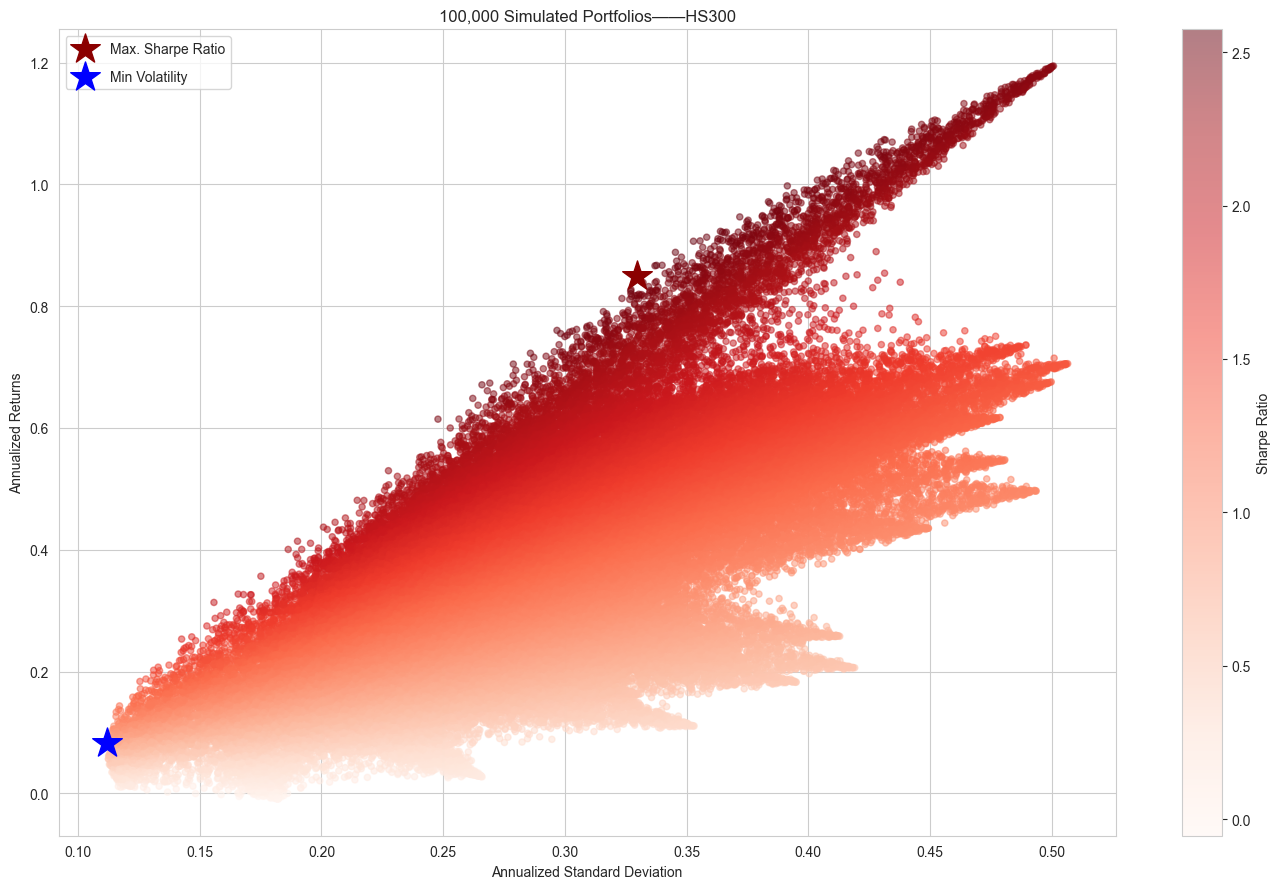

In [54]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Reds',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios——HS300')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkred', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='blue', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Run Calculation

### Get random PF

In [55]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [56]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.289092            0.367215       1.232129
std                         0.071107            0.182667       0.458394
min                         0.109933           -0.009527      -0.055203
25%                         0.239989            0.228243       0.896762
50%                         0.282940            0.343860       1.254890
75%                         0.333390            0.491800       1.537996
max                         0.506745            1.193259       2.611625


In [57]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.317196
Annualized Returns               0.828896
Sharpe Ratio                     2.611625
Name: 67236, dtype: float64

### Get Max Sharpe PF

In [58]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [59]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.766610
sd     0.280741
sr     2.728555
dtype: float64

From simulated pf data

### Get Min Vol PF

In [60]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [61]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

### Plot Result

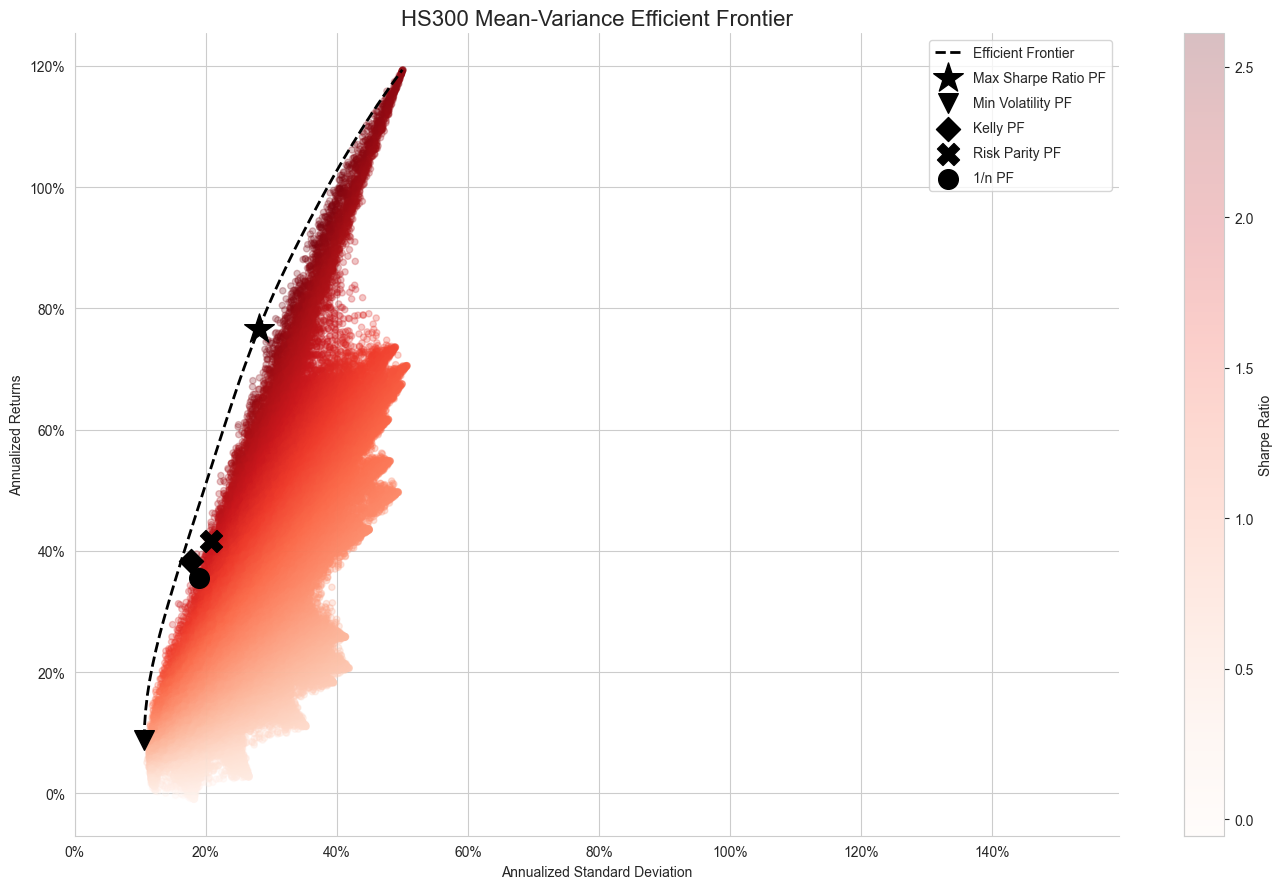

In [62]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Reds',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('HS300 Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();